# Instalar requerimientos

## Instalar modulos si no existen

In [79]:
import os
os.system(r'"C:\Program Files\Python313\python.exe" -m pip install --upgrade pip')
!pip install --quiet numpy
!pip install --quiet matplotlib
!pip install --quiet torch
!pip install --quiet torchvision
!pip install --quiet kagglehub

## Importar librerias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset,DataLoader
import kagglehub
import tqdm as notebook_tqdm
from random import shuffle
from math import floor
import shutil

## Habilitar cuda si está disponible

In [ ]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

# Cargar Dataset

## Definir funciones

### Copiar todo el contenido del folder de descarga por default del dataset de kaggle

In [ ]:
def copy_all_contents(path1, path2):
    if not os.path.exists(path2):
        os.makedirs(path2)
    
    for item in os.listdir(path1):
        src = os.path.join(path1, item)
        dst = os.path.join(path2, item)
        if os.path.isdir(src):
            shutil.copytree(src, dst, dirs_exist_ok=True)
        else:
            shutil.copy2(src, dst)

In [ ]:
# Download latest version
dataset_folder = os.path.join(os.getcwd(), "dataset_raw")
path = kagglehub.dataset_download("smeschke/four-shapes", force_download=True)

print("Path to dataset files:", path)
copy_all_contents(path, dataset_folder)


100%|██████████| 21.6M/21.6M [00:00<00:00, 25.6MB/s]

Extracting files...


Path to dataset files: C:\Users\casta\.cache\kagglehub\datasets\smeschke\four-shapes\versions\2


In [63]:
def preprocessData(dirName, ext):
    allFiles = list()
    for root, dirs, files in os.walk(dirName):
        for file in files:
            if file.endswith(ext):
                allFiles.append(os.path.join(root, file))
    shuffle(allFiles)
    split = 0.7
    split_index = floor(len(allFiles) * split)
    training = allFiles[:split_index]
    testing = allFiles[split_index:]
    return training, testing

def copyFiles(files, target):
    for file in files:
        target_folder = os.path.join(path_target, target, file.split('\\')[-2])
        
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)

        shutil.copy2(file, target_folder)

In [ ]:
path_target=os.path.join(os.getcwd(), 'dataset_preproc')

if not os.path.exists(os.path.join(os.getcwd(), 'dataset_preproc')):
    os.mkdir(os.path.join(os.getcwd(), 'dataset_preproc'))

if not os.path.exists(os.path.join(path_target, 'train')):
    os.mkdir(os.path.join(path_target, 'train'))

if not os.path.exists(os.path.join(path_target, 'valid')):
    os.mkdir(os.path.join(path_target, 'valid'))

for t in ['train', 'valid']:
    for folder in ['circle/', 'square/', 'star/', 'triangle/']:
        if not os.path.exists(os.path.join(path_target, t, folder)):
            os.mkdir(os.path.join(path_target, t, folder))

training, testing = preprocessData(os.path.join(os.getcwd(), 'dataset_raw'), '.png')

copyFiles(files = training, target = 'train')
copyFiles(files = testing, target = 'valid')

In [66]:
simple_transform = transforms.Compose([transforms.Resize((64, 64))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

In [67]:
path_target=os.path.join(os.getcwd(), 'dataset_preproc')
train_folder = os.path.join(path_target, 'train')
valid_folder = os.path.join(path_target, 'valid')

train = ImageFolder(train_folder,simple_transform)
valid = ImageFolder(valid_folder,simple_transform)

train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=3,shuffle=True)

# Definir y entrenar modelo

## Definicion del modelo

Se untilizan dos capas convolucionales y dos capas fully connected.

In [68]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(3380, 50)
        self.fc2 = nn.Linear(50, 4)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)

In [70]:
def fit(epoch, model, data_loader, phase='training', volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile = True
    running_loss = 0.0
    running_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile), Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)

        #running_loss += F.nll_loss(output, target, size_average=False).data[0]
        running_loss += F.nll_loss(output, target, size_average=False).data
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()

    loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * running_correct / len(data_loader.dataset)

    print(f'{phase} loss is {loss} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)} = {accuracy}')
    return loss, accuracy

## Entrenamiento del modelo

In [73]:
model = Net()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,5):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.3690682053565979 and training accuracy is 8809/10479 = 84.06336212158203
validation loss is 0.00796549767255783 and validation accuracy is 4486/4491 = 99.88866424560547
training loss is 0.04845324531197548 and training accuracy is 10313/10479 = 98.41587829589844
validation loss is 0.0013363426551222801 and validation accuracy is 4489/4491 = 99.9554672241211
training loss is 0.030158597975969315 and training accuracy is 10377/10479 = 99.02662658691406
validation loss is 0.0004356341087259352 and validation accuracy is 4490/4491 = 99.97772979736328
training loss is 0.02421078458428383 and training accuracy is 10389/10479 = 99.1411361694336
validation loss is 6.47647466394119e-05 and validation accuracy is 4491/4491 = 100.0


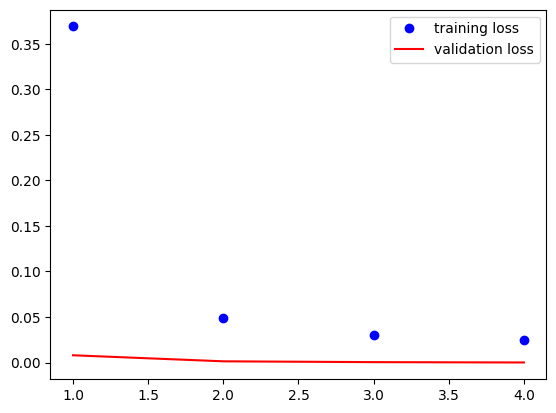

In [74]:
plt.plot(range(1, len(train_losses)+1), train_losses, 'bo', label='training loss')
plt.plot(range(1, len(val_losses)+1), val_losses, 'r', label='validation loss')
plt.legend()
plt.show()